# Data storage handler

This data handler use [PyTables](https://www.pytables.org/) that is built on top of the HDF5 library, using the Python language and the NumPy package. It features an object-oriented interface that, combined with C extensions for the performance-critical parts of the code (generated using Cython), makes it a fast, yet extremely easy to use tool for interactively browse, process and search very large amounts of data. One important feature of [PyTables](https://www.pytables.org/) is that it optimizes memory and disk resources so that data takes much less space (specially if on-flight compression is used) than other solutions such as relational or object oriented databases.

In [1]:
import tables
import numpy as np
import json
from datetime import datetime

In [2]:
filename = 'sampple_eeg.h5'
CHANNELS = 16

In [3]:
from openbci_stream.utils import HDF5Writer, HDF5Reader

## Writer

In [4]:
writer = HDF5Writer('output.h5')

### Add header

In [5]:
header = {'sample_rate': 1000,
          'datetime': datetime.now().timestamp(),
         }
writer.add_header(header)

### Add EEG data

The number of channels is defined with first data addition:

In [6]:
eeg = np.random.normal(size=(16, 1000))  # channels x data
writer.add_eeg(eeg)

The number of channels can not be changed after define the first package:

In [8]:
eeg = np.random.normal(size=(8, 1000))
writer.add_eeg(eeg)

Is possible to add any amount of data:

In [9]:
eeg = np.random.normal(size=(16, 500))
writer.add_eeg(eeg)

A `timestamp` can be added to the data, in a separate command, in this case, `timestamp` _could_ be an array of the same length of data.

In [10]:
eeg = np.random.normal(size=(16, 2000))
timestamp = np.array([datetime.now().timestamp()]*2000)

writer.add_eeg(eeg)
writer.add_timestamp(timestamp)

Is possible to use the `timestamp` in a single command.

In [11]:
eeg = np.random.normal(size=(16, 2000))
timestamp = [datetime.now().timestamp()] * 2000

writer.add_eeg(eeg, timestamp)

### Extrapolated timestamps

Usually, we never have the `datetimes` for each value in a package, instead,  we have a single marker time for each package. This module was designed keeping mind these cases, so, is possible to set a single `timestamp` and `HDF5Reader` will interpolate the missing `timestamps`

In [11]:
eeg = np.random.normal(size=(16, 2000))
timestamp = datetime.now().timestamp()

writer.add_eeg(eeg, timestamp)

### Add markers

The `markers` can be added individually with their respective `timestamp`:

In [12]:
timestamp = datetime.now().timestamp()
marker = 'LEFT'
writer.add_marker(marker, timestamp)

Or in a dictionary structure with the marker as `key` and events as a list of `timestamps`:

In [13]:
markers = {
    'LEFT': [1603150888.752062, 1603150890.752062, 1603150892.752062],
    'RIGHT': [1603150889.752062, 1603150891.752062, 1603150893.752062],
} 

writer.add_markers(markers)

### Add annotations



The annotations are defined like in EDF format, with an `onset` and `duration` in seconds, and their corresponding `description`:

In [14]:
writer.add_annotation(onset=5, duration=1, description='This is an annotation, in EDF style')
writer.add_annotation(onset=45, duration=15, description='Electrode verification')
writer.add_annotation(onset=50, duration=3, description='Patient blinking')

Do no forget to close the file

In [15]:
writer.close()

## Reader

In [16]:
reader = HDF5Reader('output.h5')

reader.header

{'sample_rate': 1000, 'datetime': 1603571026.154923}

In [17]:
reader.eeg

array([[ 0.10438297,  0.64116283,  0.87643178, ..., -2.37731593,
        -0.46304589, -0.29561915],
       [ 1.18485957, -1.108576  , -0.51729158, ..., -0.23877551,
         0.40733376,  0.46088901],
       [ 0.81630461, -0.23760924, -0.28369799, ..., -0.59499498,
        -0.08253127,  0.05682365],
       ...,
       [-0.73725065, -0.18386757,  1.0493811 , ..., -0.91611828,
        -0.41891577,  0.25832004],
       [ 1.02737675,  0.14142223,  0.4126109 , ..., -1.68713906,
        -1.91103092,  0.02872794],
       [ 1.34338115, -1.93427996, -0.79767577, ..., -0.74610469,
         0.98137138,  0.64254865]])

In [18]:
reader.markers

{'LEFT': [1603571026.232075,
  1603150888.752062,
  1603150890.752062,
  1603150892.752062],
 'RIGHT': [1603150889.752062, 1603150891.752062, 1603150893.752062]}

In [19]:
reader.f.root.eeg_data

/eeg_data (EArray(16, 7500)) 'EEG time series'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 1
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (16, 512)

In [20]:
reader.f.root.timestamp

/timestamp (EArray(6000,)) 'EEG timestamp'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (8192,)

In [21]:
reader.timestamp

In [22]:
reader.annotations

[[5, 1, 'This is an annotation, in EDF style'],
 [45, 15, 'Electrode verification'],
 [50, 3, 'Patient blinking']]

## Examples using the `with` control-flow structure

This data format handlers can be used with the `with` structure:

### Writer

This example create a file with random data:

In [1]:
from openbci_stream.utils import HDF5Writer
from datetime import datetime, timedelta
import numpy as np
import os

now = datetime.now()

header = {'sample_rate': 1000,
          'datetime': now.timestamp(),
          'montage': 'standard_1020',
          'channels': {i:ch for i, ch in enumerate('Fp1,Fp2,F7,Fz,F8,C3,Cz,C4,T5,P3,Pz,P4,T6,O1,Oz,O2'.split(','))},
         }

filename = 'sample-eeg.h5'
if os.path.exists(filename):
    os.remove(filename)

with HDF5Writer(filename) as writer:

    writer.add_header(header)
    
    for i in range(60*5):
        eeg = np.random.normal(size=(16, 1000))
        aux = np.random.normal(size=(3, 1000))
        timestamp = (now + timedelta(seconds=i+1)).timestamp()
        writer.add_eeg(eeg, timestamp)
        writer.add_aux(aux)
    
#     events = np.linspace(1, 59*30, 15*30).astype(int)*1000
#     np.random.shuffle(events)
    markers = {}
    for i in range(5, 60*5//4, 4):
        markers.setdefault('RIGHT', []).append((now + timedelta(seconds=i+1)).timestamp())
        markers.setdefault('LEFT', []).append((now + timedelta(seconds=i+2)).timestamp())
        markers.setdefault('UP', []).append((now + timedelta(seconds=i+3)).timestamp())
        markers.setdefault('DOWN', []).append((now + timedelta(seconds=i+4)).timestamp())
    writer.add_markers(markers)
    
    
    writer.add_annotation((now + timedelta(seconds=10)).timestamp(), 1, 'Start run')
    writer.add_annotation((now + timedelta(seconds=60)).timestamp(), 1, 'Head moved')
    writer.add_annotation((now + timedelta(seconds=190)).timestamp(), 1, 'Blink')
    

### Reader

<ipython-input-2-ab8bda269688>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(channels)


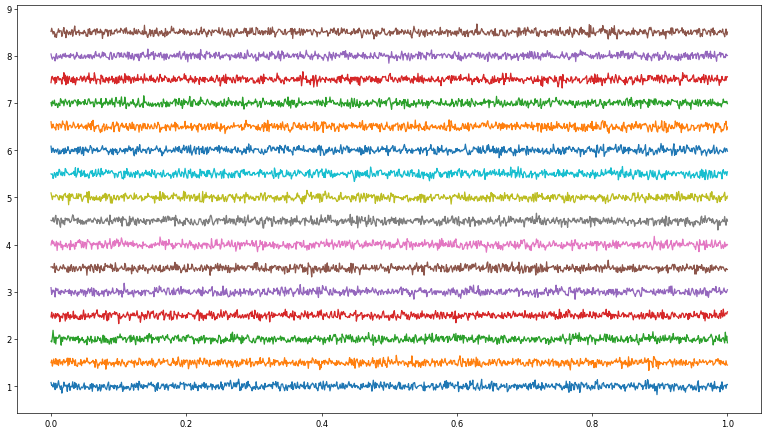

In [2]:
from openbci_stream.utils import HDF5Reader
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 9), dpi=60)

ax = plt.subplot(111)
filename = 'sample-eeg.h5'
with HDF5Reader(filename) as reader:
    
    channels = reader.header['channels']
    sample_rate = reader.header['sample_rate']

    t = np.linspace(0, 1, sample_rate)
    for i, ch in enumerate(reader.eeg[:, :sample_rate]):
        plt.plot(t, (ch-ch.mean())*0.1+i)
    ax.set_yticklabels(channels)

## MNE objects

`reader.mne_epochs()` return an object [mne.EpochsArray](https://mne.tools/stable/generated/mne.EpochsArray.html):

In [3]:
reader = HDF5Reader('sample-eeg.h5')

epochs = reader.get_epochs(duration=6, tmin=-2, markers=['RIGHT', 'LEFT'])

36 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[mne.EpochsArray](https://mne.tools/stable/generated/mne.EpochsArray.html) needs an array of shape `(epochs, channels, time)`, we have channels and time, we only need to separate the epochs, here, an epoch is a trial, we will select trial by slicing around a `marker`. The argument `duration` in seconds set the _width_ for the trials, and `tim` set _how much_ of signal before the marker will I analyze, finally, the argument `markers` set the labels to use, if empty, then will use all of them.

This feature needs at least `montage`, `channels`, and `sample_rate` configured in the header.

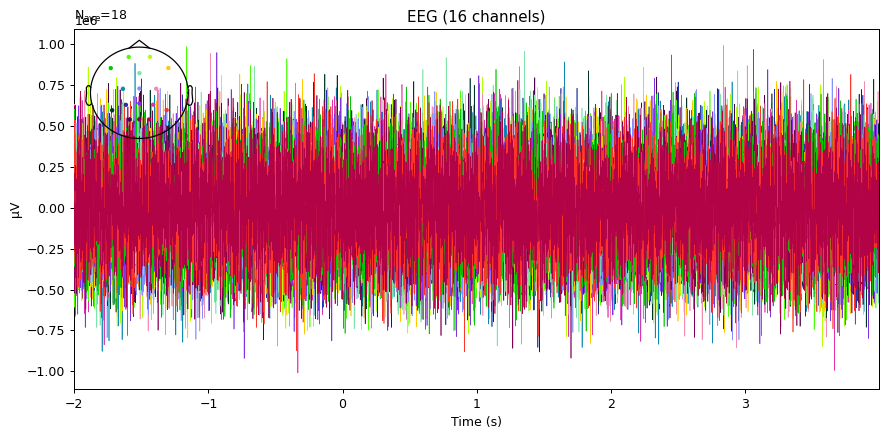

In [4]:
evoked = epochs['RIGHT'].average()

fig = plt.figure(figsize=(10, 5), dpi=90)
ax = plt.subplot(111)
evoked.plot(axes=ax, spatial_colors=True);

_This is only random data._

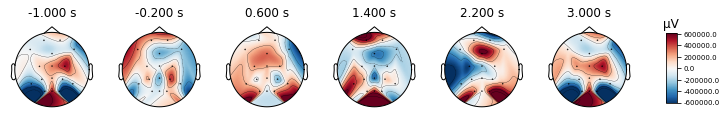

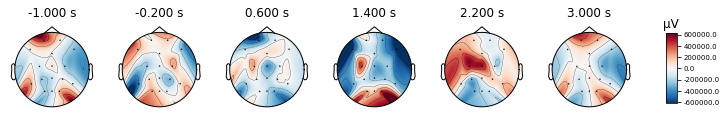

In [5]:
times = np.linspace(-1, 3, 6)

epochs['LEFT'].average().plot_topomap(times,)
epochs['RIGHT'].average().plot_topomap(times,);

## Export to EDF

The European Data Format (EDF) is a standard file format designed for exchange and storage of medical time series, is possible to export to this format with the `to_edf` method. This file format needs special keys in the `header`:

  * **admincode:** str with the admincode.
  * **birthdate:** date object with the the birthdate of the patient.
  * **equipment:** str thats describes the measurement equpipment.
  * **gender:** int with the the gender, 1 is male, 0 is female.
  * **patientcode:** str with the patient code.
  * **patientname:** str with the patient name.
  * **patient_additional:** str with the additional patient information.
  * **recording_additional:** str wit the additional recording information.
  * **technician:** str with the technicians name.

In [6]:
reader = HDF5Reader('sample-eeg.h5')
reader.to_edf('sample-eeg.edf')

## Relative time markers

In the previous examples, we are using the markers with a `timestamp`, this is an **absolute** reference, is an exact point in time, the reason of that is because this feature was designed for real-time streaming, in this kind of implementations the main reference is the system clock, this approach makes easy to implement a markers register in an isolated system.

But, is possible to get relative time markers, based on the position in the data array:

In [5]:
reader.markers_relative

{'RIGHT': [1000,
  5000,
  9000,
  13000,
  17000,
  21000,
  25000,
  29000,
  33000,
  37000,
  41000,
  45000,
  49000,
  53000,
  57000,
  61000,
  65000,
  69000,
  73000,
  77000,
  81000,
  85000,
  89000,
  93000,
  97000,
  101000,
  105000,
  109000,
  113000,
  117000,
  121000,
  125000,
  129000,
  133000,
  137000,
  141000,
  145000,
  149000,
  153000,
  157000,
  161000,
  165000,
  169000,
  173000,
  177000,
  181000,
  185000,
  189000,
  193000,
  197000,
  201000,
  205000,
  209000,
  213000,
  217000,
  221000,
  225000,
  229000,
  233000,
  237000,
  241000,
  245000,
  249000,
  253000,
  257000,
  261000,
  265000,
  269000,
  273000,
  277000,
  281000,
  285000,
  289000,
  293000,
  297000,
  301000,
  305000,
  309000,
  313000,
  317000,
  321000,
  325000,
  329000,
  333000,
  337000,
  341000,
  345000,
  349000,
  353000,
  357000,
  361000,
  365000,
  369000,
  373000,
  377000,
  381000,
  385000,
  389000,
  393000,
  397000,
  401000,
  405000,